In [2]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import os
from __future__ import print_function, division
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [50]:
data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "data/train/images"
TRAIN_ANNOTATIONS_PATH = "data/train/annotation.json" #280000 images
TRAIN_ANNOTATIONS_SMALL_PATH = "data/train/annotation-small.json" #8366 images

In [51]:
coco = COCO(TRAIN_ANNOTATIONS_SMALL_PATH)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [5]:
category_ids = coco.loadCats(coco.getCatIds())
print(category_ids)

[{'id': 100, 'name': 'building', 'supercategory': 'building'}]


In [6]:
image_ids = coco.getImgIds(catIds=coco.getCatIds())

print(len(image_ids))

8366


In [9]:
random_image_id = random.choice(image_ids)

In [14]:
img = coco.loadImgs(random_image_id)[0]

[{'id': 157123, 'file_name': '000000157123.jpg', 'width': 300, 'height': 300}]


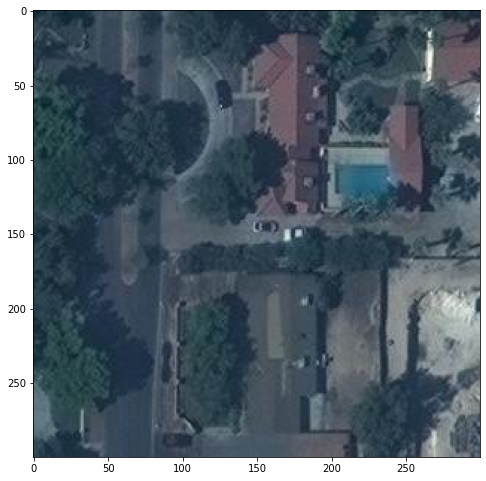

In [11]:
image_path = os.path.join(TRAIN_IMAGES_DIRECTORY, img["file_name"])
I = io.imread(image_path)
plt.imshow(I)
plt.show()

In [19]:
annotation_ids = coco.getAnnIds(imgIds=img['id'])
annotations = coco.loadAnns(annotation_ids)

In [20]:
print(annotations)

[{'id': 1339418, 'image_id': 157123, 'segmentation': [[236.0, 127.0, 236.0, 67.0, 256.0, 67.0, 256.0, 87.0, 258.0, 87.0, 258.0, 127.0, 236.0, 127.0]], 'area': 1280.0, 'bbox': [67.0, 236.0, 189.0, 22.0], 'category_id': 100, 'iscrowd': 0}, {'id': 1339417, 'image_id': 157123, 'segmentation': [[195.0, 141.0, 146.0, 141.0, 146.0, 113.0, 154.0, 114.0, 155.0, 55.0, 146.0, 55.0, 147.0, 19.0, 195.0, 18.999999999999996, 195.0, 141.0]], 'area': 5463.0, 'bbox': [113.0, 146.0, 82.0, 49.0], 'category_id': 100, 'iscrowd': 0}, {'id': 1339416, 'image_id': 157123, 'segmentation': [[300.0, 50.99999999999999, 265.0, 49.99999999999999, 265.0, 9.999999999999993, 300.0, 9.999999999999991, 300.0, 50.99999999999999]], 'area': 1417.0, 'bbox': [49.99999999999999, 265.0, 250.0, 35.0], 'category_id': 100, 'iscrowd': 0}, {'id': 1339415, 'image_id': 157123, 'segmentation': [[187.0, 262.0, 177.0, 262.0, 177.0, 287.0, 140.0, 287.0, 140.0, 181.0, 187.0, 181.0, 187.0, 262.0]], 'area': 4732.0, 'bbox': [140.0, 140.0, 147.

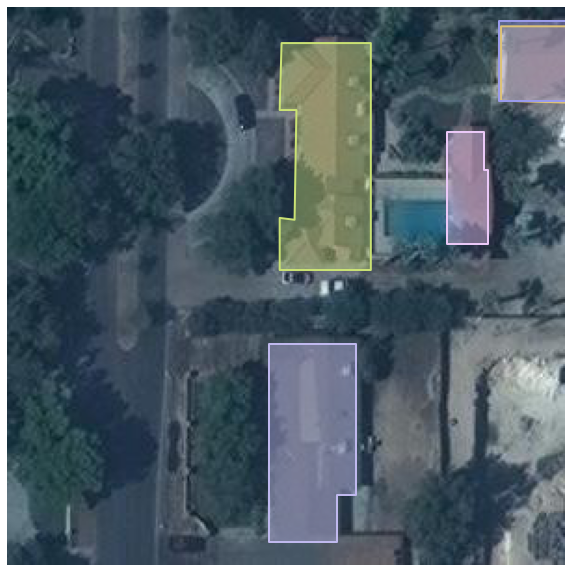

In [21]:
plt.imshow(I); plt.axis('off')
# Render annotations on top of the image
coco.showAnns(annotations)

In [22]:
ann_segmentation = annotations[0]['segmentation']

from pycocotools import mask as cocomask
rle = cocomask.frPyObjects(ann_segmentation, img['height'], img['width'])
print(rle)

[{'size': [300, 300], 'counts': b'cVU2l1`70000000000000000000000000000000000000d0\\O00QW<'}]


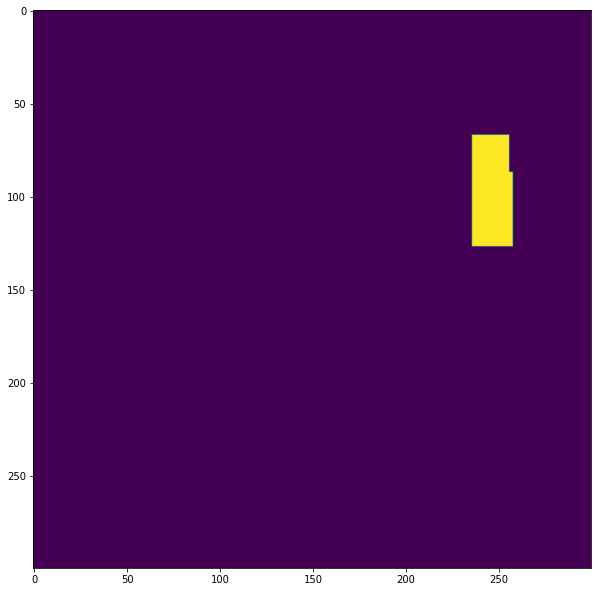

In [23]:
from pycocotools import mask as cocomask
rle = cocomask.frPyObjects(annotations[0]['segmentation'], img['height'], img['width'])
m = cocomask.decode(rle)
# m.shape has a shape of (300, 300, 1)
# so we first convert it to a shape of (300, 300)
m = m.reshape((img['height'], img['width']))
plt.imshow(m)

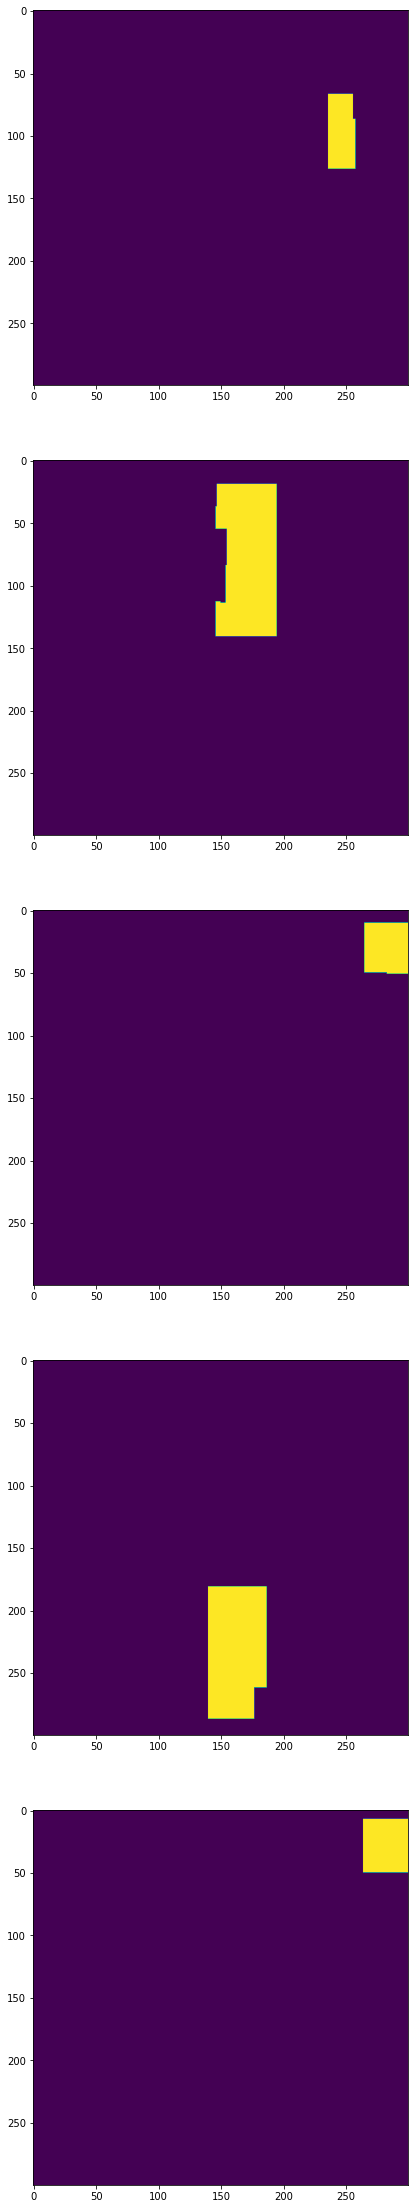

In [35]:
pylab.rcParams['figure.figsize'] = (10, 40.0)

mask = np.zeros((img['height'], img['width']))

for _idx, annotation in enumerate(annotations):
    plt.subplot(len(annotations), 1, _idx+1)
    rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
    m = cocomask.decode(rle)
    # m.shape has a shape of (300, 300, 1)
    # so we first convert it to a shape of (300, 300)
    m = m.reshape((img['height'], img['width']))
    mask = m + mask
    plt.imshow(m)



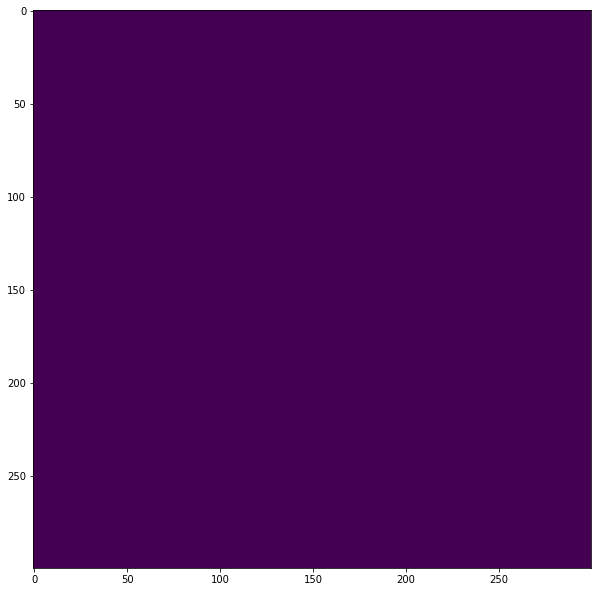

In [47]:
mask[mask > 0] = 1
plt.imshow(mask)

In [72]:
class imageDataset(Dataset):
    def __init__(self, annotaions_dir, images_dir, transform=None):
        self.annotaions_dir = annotaions_dir
        self.images_dir = images_dir
        self.transform = transform
        self.coco = COCO(annotaions_dir)
        self.category_ids = coco.loadCats(coco.getCatIds())
        self.image_ids = coco.getImgIds(catIds=coco.getCatIds())

        
    def __len__(self):
        return len(self.image_ids)
    
    def  __getitem__(self, idx):
        img = coco.loadImgs(idx)[0]
        
        image_path = os.path.join(self.images_dir, img["file_name"])
        I = io.imread(image_path)

        
        annotation_ids = coco.getAnnIds(imgIds = img['id'])
        annotations = coco.loadAnns(annotation_ids)
        
        mask = np.zeros((img['height'], img['width']))
        for annotation in annotations:
            rle = cocomask.frPyObjects(annotation['segmentation'], img['height'], img['width'])
            m = cocomask.decode(rle)
            m = m.reshape((img['height'], img['width']))
            mask = mask + m
            
        mask[mask > 0] = 1
        return I, mask

In [73]:
loader = imageDataset(TRAIN_ANNOTATIONS_SMALL_PATH, TRAIN_IMAGES_DIRECTORY)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


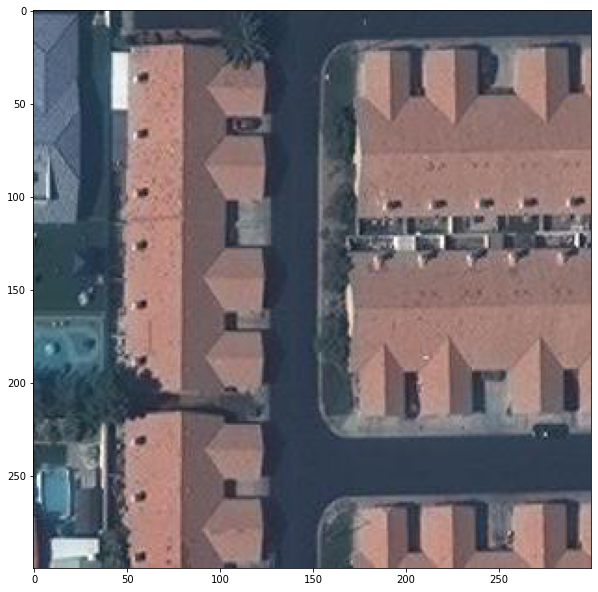

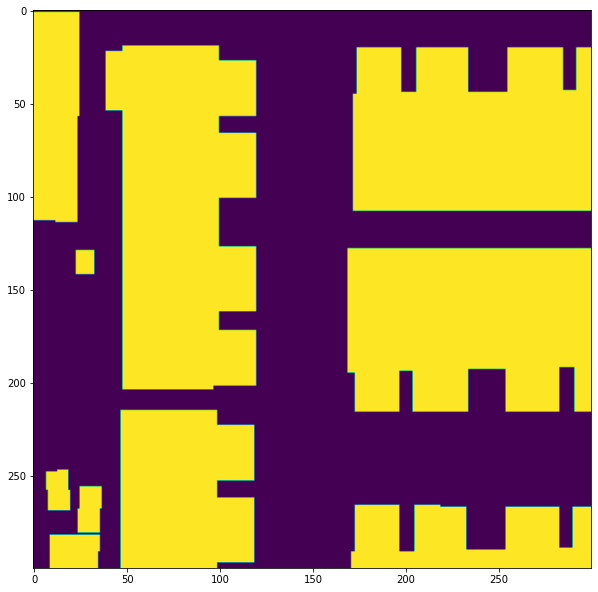

In [77]:
img,mask=loader.__getitem__(random.choice(image_ids))
plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()